## Analyze oscillations in one-canyon conduino timeseries

Analyze experiments S


In [53]:
import cmocean as cmo
import glob
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy import signal
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools

In [15]:
sns.set_style('white')
sns.set_context('notebook')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(15, color=col, linestyle=':')
    ax.axvline(21.0+15, color=col, linestyle=':')
    ax.axvline(71.0+15, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [5]:
# Information for all runs is stored in experiment_dictionaries.py
lib_path = os.path.abspath('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts') # Add absolute path to my python scripts
sys.path.append(lib_path)

import experiment_dictionaries as exdic

In [6]:
exp_dicts = [exdic.S01, exdic.S02, exdic.S03, exdic.S04, 
             exdic.S05, exdic.S06, exdic.S07, exdic.S08,
             exdic.S09, exdic.S10, exdic.S11, exdic.S12]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']

### Probe readings

../experiments/exp_19aug19/04_experiment1.mat
../experiments/exp_19aug19/08_experiment2.mat
../experiments/exp_19aug19/11_experiment3.mat
../experiments/exp_20aug19/04_experiment1.mat
../experiments/exp_20aug19/08_experiment2.mat
../experiments/exp_20aug19/12_experiment3.mat
../experiments/exp_21aug19/04_experiment1.mat
../experiments/exp_21aug19/07_experiment2.mat
../experiments/exp_21aug19/11_experiment3.mat
../experiments/exp_22aug19/04_experiment1.mat
../experiments/exp_22aug19/07_experiment2.mat
../experiments/exp_22aug19/11_experiment3.mat


Text(0.5,0,'time / s')

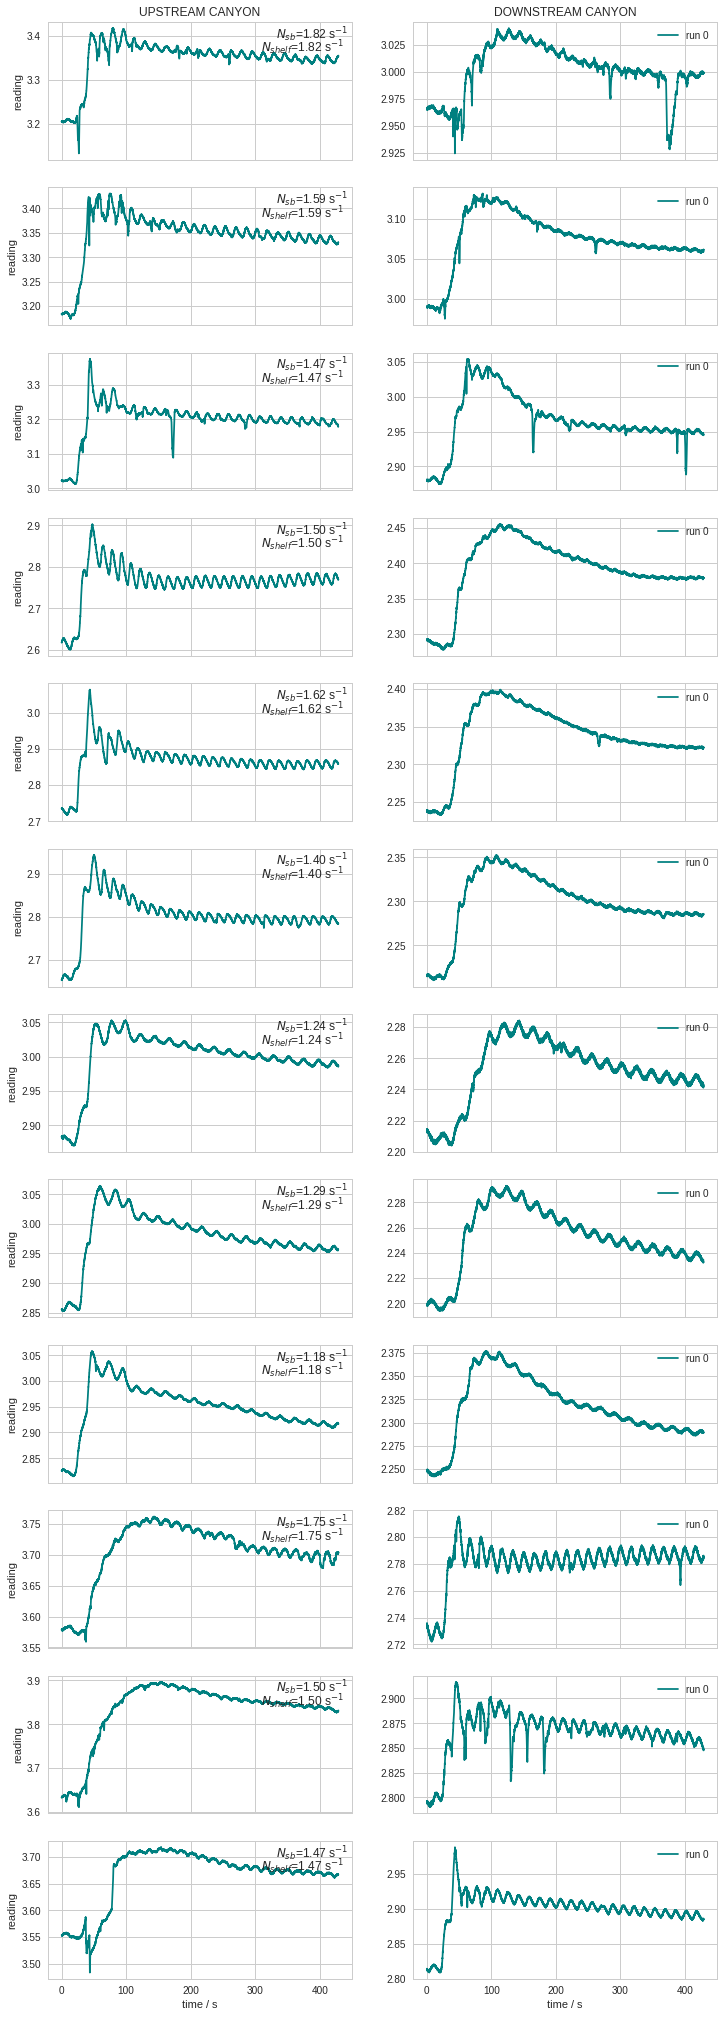

In [12]:
fig, ax = plt.subplots(exp_num, 2, figsize=(12,exp_num*3), sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')

for exp, kk in zip(exp_dicts, range(exp_num)):
    
    for ii, col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        print(filepath)
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        ax[kk,0].plot(time,P1,'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time,P2,'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.75,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.7,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
       
    ax[kk,0].set_ylabel('reading')
    ax[kk,1].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')

### Density difference

8.975979010256552
8.975979010256552
8.975979010256552
7.853981633974483
7.853981633974483
7.853981633974483
12.566370614359172
12.566370614359172
12.566370614359172
8.975979010256552
8.975979010256552
8.975979010256552


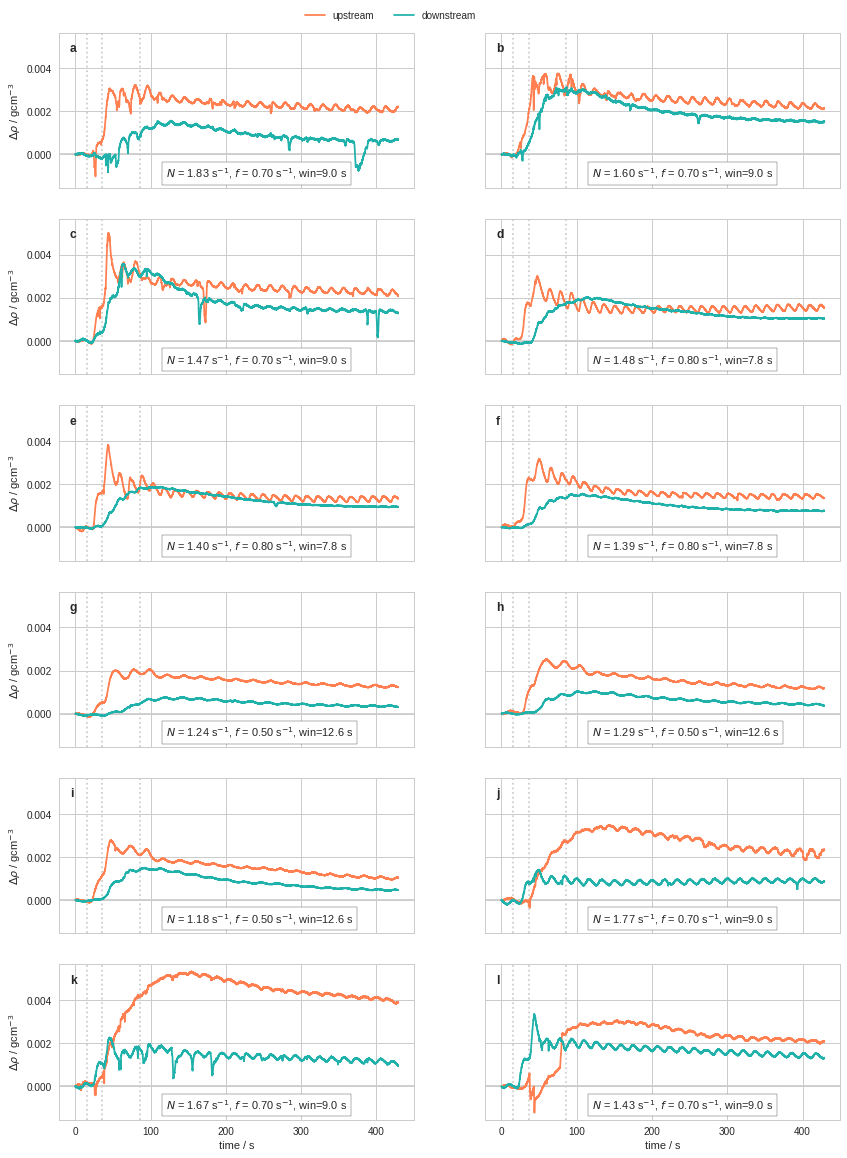

In [24]:
sns.set_style('whitegrid')
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(14,20), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l']
rho0=998.5
g = 9.81
for exp, kk, ax, pan_lab in zip(exp_dicts, range(exp_num), axs, panel_labels):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        inertial_period = 1/((exp["fo"])/(2*np.pi))
        win = int(inertial_period/dt)
        print(inertial_period)
        ax.axhline(0, color='0.8')
        plot_uprofile(ax)
        ax.text(0.3,0.07,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, win=%1.1f s' \
                %(N,exp["fo"],win*dt), transform=ax.transAxes,fontsize=11,
                bbox=dict(facecolor='white', alpha=1) )
    
        ax.plot(time, dens1-dens1[0],'-',
                color='coral', label='upstream')
        ax.plot(time, dens2-dens2[0],'-',
                color='lightseagreen', label='downstream')
        ax.text(0.03,0.88, pan_lab, fontweight='bold', transform=ax.transAxes)

for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel(r'$\Delta \rho$ / gcm$^{-3}$')
ax10.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax1.legend(ncol=3,bbox_to_anchor=(0,1.2))

0.05570423008216337
0.05570423008216337
0.05570423008216337
0.06366197723675814
0.06366197723675814
0.06366197723675814
0.039788735772973836
0.039788735772973836
0.039788735772973836
0.05570423008216337
0.05570423008216337
0.05570423008216337


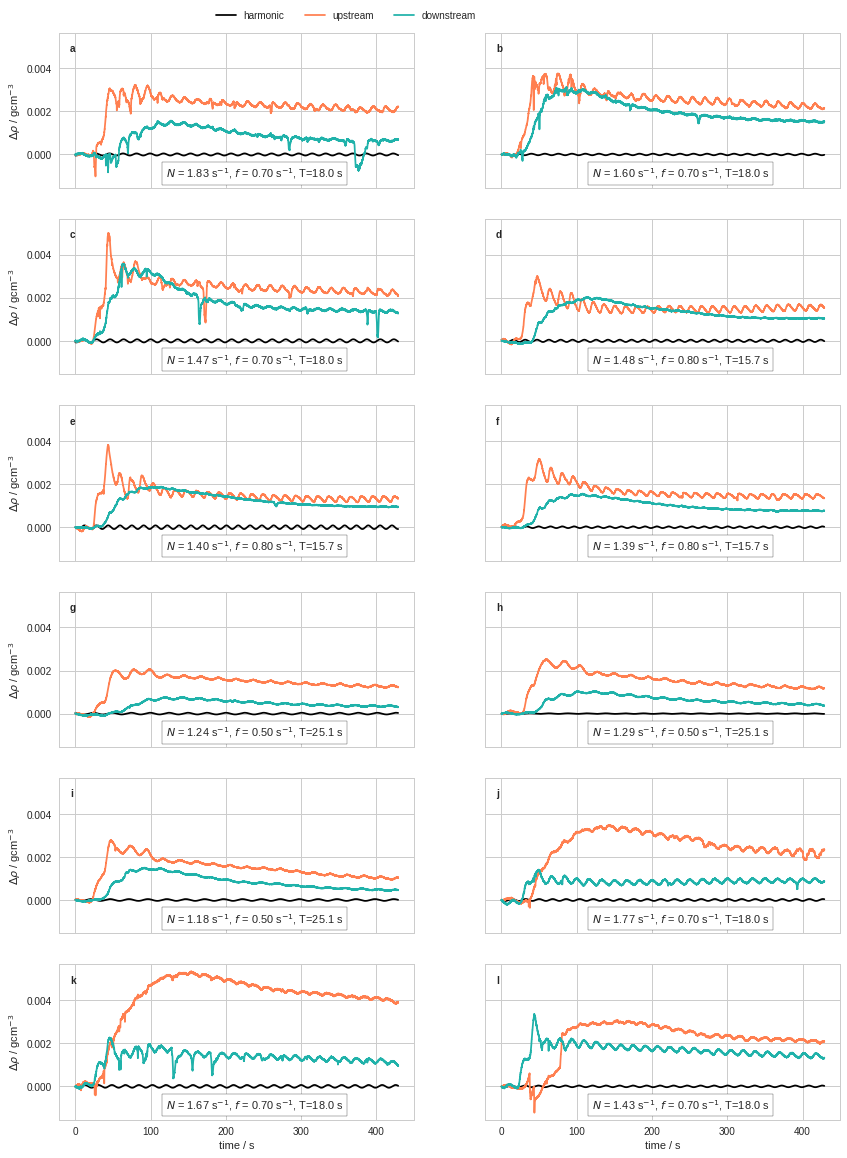

In [153]:
sns.set_style('whitegrid')
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(14,20), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l']
rho0=998.5
g = 9.81
for exp, kk, ax, pan_lab in zip(exp_dicts, range(exp_num), axs, panel_labels):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        print(f0)
        res_ups, har_ups = ctools.filter_freq(time[:], (dens1[:]-dens1[0]),f0)
        inertial_period=1/f0
        ax.plot(time[:],har_ups,'-', label='harmonic', color='k')
        ax.text(0.3,0.07,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, T=%1.1f s' \
                %(N,exp["fo"],inertial_period), transform=ax.transAxes,fontsize=11,
                bbox=dict(facecolor='white', alpha=1) )
    
        ax.plot(time, dens1-dens1[0],'-',
                color='coral', label='upstream')
        ax.plot(time, dens2-dens2[0],'-',
                color='lightseagreen', label='downstream')
        ax.text(0.03,0.88, pan_lab, fontweight='bold', transform=ax.transAxes)

for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel(r'$\Delta \rho$ / gcm$^{-3}$')
ax10.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax1.legend(ncol=3,bbox_to_anchor=(0,1.2))

### Frequency Spectra

0.05570423008216337 10.929520300395177 10.940012639883555
0.05570423008216337 10.930541182447715 10.92937525805492
0.05570423008216337 10.932882757534394 10.88740196526305
0.06366197723675814 10.93042475791505 10.938586141734294
0.06366197723675814 10.931004799862855 10.93683466908945
0.06366197723675814 10.93246913898825 10.89865136778498
0.039788735772973836 10.932656282625342 10.8941733325105
0.039788735772973836 10.842523165668347 10.899815422530297
0.039788735772973836 10.932272777136294 10.912448922500419
0.05570423008216337 10.929834338826796 10.947322073768918
0.05570423008216337 10.929870680661422 10.966012119712142
0.05570423008216337 10.930782361267166 10.943607812571054


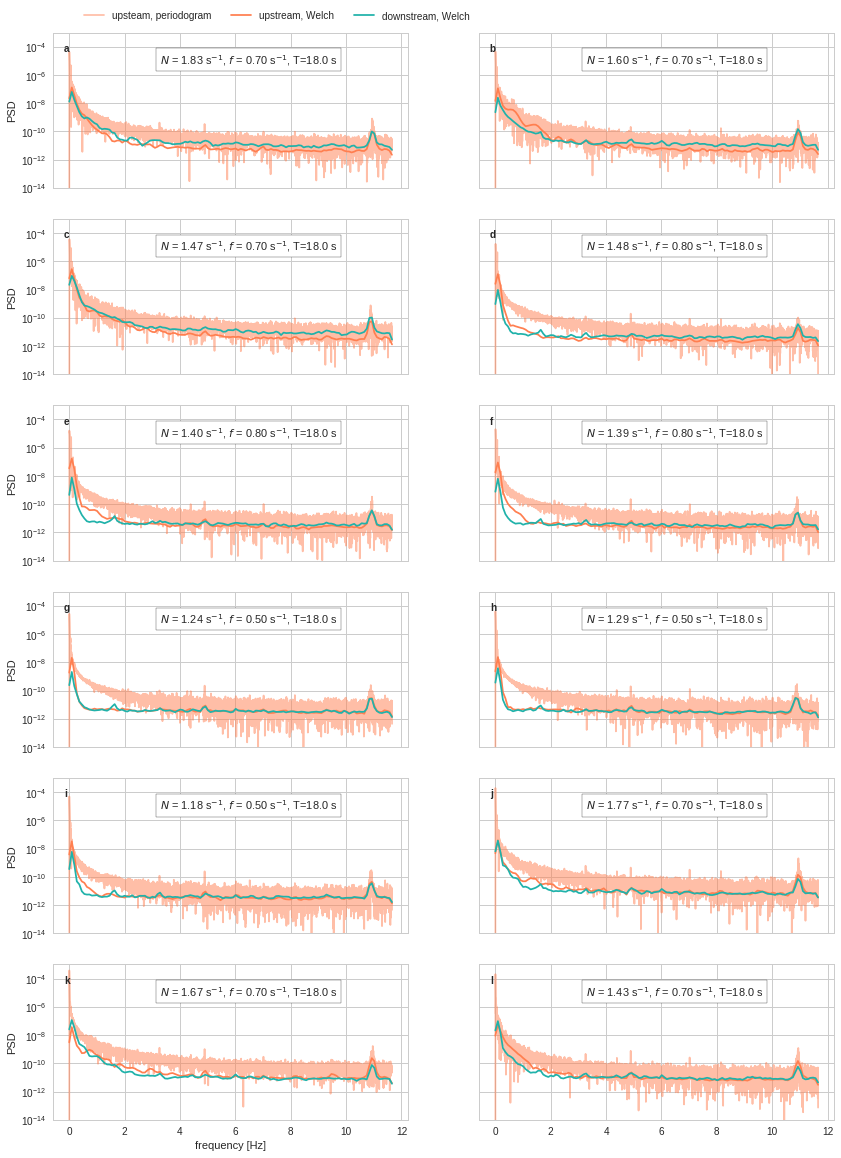

In [140]:
sns.set_style('whitegrid')
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(14,20), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l']
rho0=998.5
g = 9.81
for exp, kk, ax, pan_lab in zip(exp_dicts, range(exp_num), axs, panel_labels):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        samp_freq = len(time)/np.max(time) # Hz
        
        freq, Pxx_den = signal.welch(dens1-dens1[0], samp_freq, detrend='constant')
        freq_per, Pxx_den_per = signal.periodogram(dens1-dens1[0], samp_freq,detrend='constant')
        freq2, Pxx_den2 = signal.welch(dens2-dens2[0], samp_freq)
        
        print(f0,(freq[100:][np.argmax(Pxx_den[100:])]),(freq_per[4000:][np.argmax(Pxx_den_per[4000:])]))
        ax.semilogy(freq_per, Pxx_den_per, color='coral', alpha=0.5, label='upsteam, periodogram')
        ax.semilogy(freq, Pxx_den,color='coral', label='upstream, Welch')
        ax.semilogy(freq2, Pxx_den2,color='lightseagreen', label='downstream, Welch')
        
        #ax.axvline(f0,color='k')
        #ax.axvline(f0, color='0.5')
        
        ax.text(0.3,0.8,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, T=%1.1f s' \
                %(N,exp["fo"],inertial_period), transform=ax.transAxes,fontsize=11,
                bbox=dict(facecolor='white', alpha=1) )
        ax.text(0.03,0.88, pan_lab, fontweight='bold', transform=ax.transAxes)
        ax.set_ylim(1E-14,1E-3)
        
for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel('PSD')

ax10.set_xlabel('frequency [Hz]')

ax1.legend(ncol=3,bbox_to_anchor=(0,1.2))

0.05570423008216337 0.06062240593285857 0.06062240593285857
0.05570423008216337 0.06062806842530999 0.034977731783832684
0.05570423008216337 0.06064105636179077 0.06064105636179077
0.06366197723675814 0.06995471845065633 0.034977359225328165
0.06366197723675814 0.06762648302848487 0.03497921535956114
0.06366197723675814 0.06763554240654064 0.0349839012447624
0.039788735772973836 0.03498450010440109 0.044313700132241375
0.039788735772973836 0.044317674519168765 0.044317674519168765
0.039788735772973836 0.044312145656659106 0.044312145656659106
0.05570423008216337 0.06062414779935929 0.06062414779935929
0.05570423008216337 0.03497558617811655 0.060624349375402016
0.05570423008216337 0.04430610450433625 0.06062940616382856


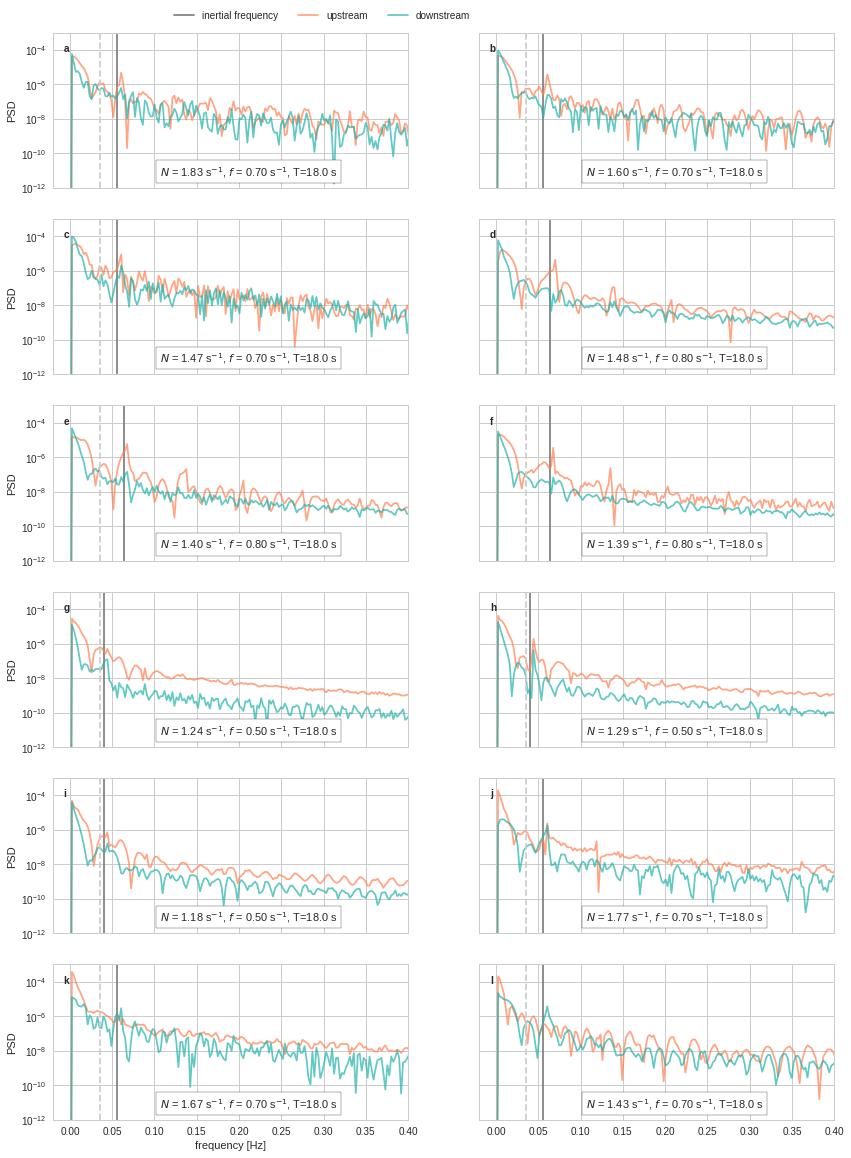

In [155]:
sns.set_style('whitegrid')
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(14,20), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l']
rho0=998.5
g = 9.81

freqs_ups = np.empty(len(exp_dicts))

for exp, kk, ax, pan_lab in zip(exp_dicts, range(exp_num), axs, panel_labels):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        f0 = (exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        samp_freq = len(time)/np.max(time) # Hz
        ax.axvline(f0,color='0.5', label='inertial frequency')
        
        freq_per, Pxx_den_per = signal.periodogram(dens1-dens1[0], samp_freq,detrend='constant')
        freq_per2, Pxx_den_per2 = signal.periodogram(dens2-dens2[0], samp_freq,detrend='constant')
        #freq_per_anom, Pxx_den_per_anom = signal.periodogram(dens1-dens2, samp_freq,detrend='constant')
        print(f0,freq_per[15:][np.argmax(Pxx_den_per[15:])],freq_per2[15:][np.argmax(Pxx_den_per2[15:])])
        freqs_ups[kk] = freq_per[15:][np.argmax(Pxx_den_per[15:])]
        
        ax.semilogy(freq_per, Pxx_den_per, color='coral', alpha=0.7, label='upstream')
        ax.semilogy(freq_per2, Pxx_den_per2,color='lightseagreen', label='downstream', alpha=0.7)
        #ax.semilogy(freq_per_anom, Pxx_den_per_anom,color='k', label='ups-dns', alpha=0.7)
        
        ax.axvline(freq_per[15],color='0.8', linestyle='--')
        
        ax.text(0.3,0.08,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, T=%1.1f s' \
                %(N,exp["fo"],inertial_period), transform=ax.transAxes,fontsize=11,
                bbox=dict(facecolor='white', alpha=1) )
        ax.text(0.03,0.88, pan_lab, fontweight='bold', transform=ax.transAxes)
        ax.set_ylim(1E-12,1E-3)
        ax.set_xlim(-0.02,0.4)
for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel('PSD')

ax10.set_xlabel('frequency [Hz]')

ax1.legend(ncol=3,bbox_to_anchor=(0,1.2))

In [71]:
1/(0.09107933583662647)

10.979438868479999

In [114]:
samp_freq = len(time)/np.max(time) # Hz
samp_freq

23.319002370703288

In [116]:
samp_period = 1/samp_freq
samp_period

0.042883481210000005

0.06062240593285857
0.06062806842530999
0.06064105636179077
0.06995471845065633
0.06762648302848487
0.06763554240654064
0.03498450010440109
0.044317674519168765
0.044312145656659106
0.06062414779935929
0.03497558617811655
0.04430610450433625


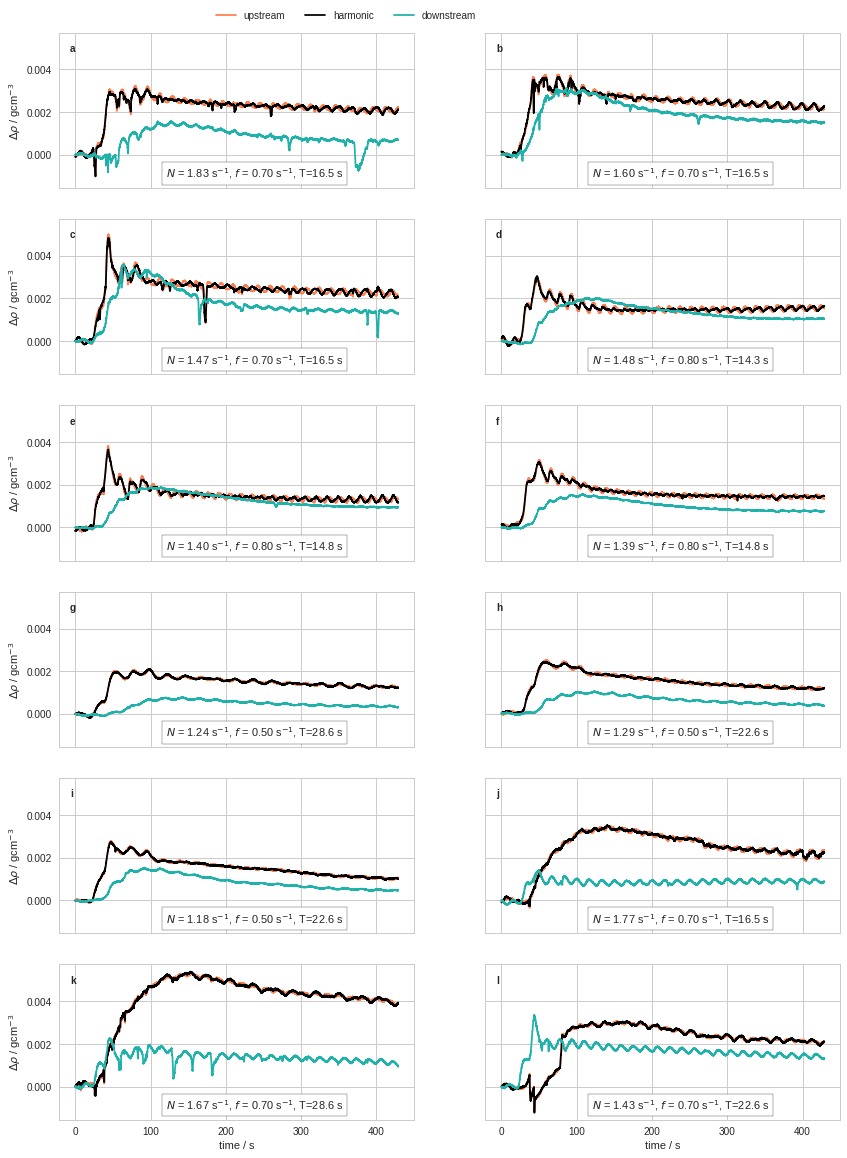

In [158]:
sns.set_style('whitegrid')
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7),(ax8,ax9),(ax10,ax11)) = plt.subplots(6, 2, figsize=(14,20), 
                                                                                    sharey=True, sharex=True)
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11]
panel_labels = ['a','b','c','d','e','f','g','h','i','j','k','l']
rho0=998.5
g = 9.81
for exp, kk, ax, pan_lab, freq in zip(exp_dicts, range(exp_num), axs, panel_labels, freqs_ups):
    for ii,col in zip(range(len(exp['run_files'])),colors): 
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        if exp['calibration']=='09Aug19':
            dens1 = ctools.densANK1_09Aug19(P1)
            dens2 = ctools.densANK2_09Aug19(P2)
        else:
            dens1 = ctools.densANK1_17Aug19(P1)
            dens2 = ctools.densANK2_17Aug19(P2)
        
        N =((g/rho0)*((1000*exp["rho_sb"][ii]-1000*exp["rho_top"][ii])/(exp["hsb"]*0.01)))**0.5
        
        f0 = freq#(exp["fo"]/2)/(2*np.pi) # f/2 is omega, table speed in rad/s, /2pi to get rid of rad
        print(f0)
        res_ups, har_ups = ctools.filter_freq(time[:], (dens1[:]-dens1[0]),f0)
        inertial_period=1/f0
        ax.text(0.3,0.07,'$N$ = %1.2f s$^{-1}$, $f$ = %1.2f s$^{-1}$, T=%1.1f s' \
                %(N,exp["fo"],inertial_period), transform=ax.transAxes,fontsize=11,
                bbox=dict(facecolor='white', alpha=1) )
    
        ax.plot(time, dens1-dens1[0],'-',
                color='coral', label='upstream')
        ax.plot(time[:],res_ups,'-', label='harmonic', color='k')
        
        ax.plot(time, dens2-dens2[0],'-',
                color='lightseagreen', label='downstream')
        ax.text(0.03,0.88, pan_lab, fontweight='bold', transform=ax.transAxes)

for ax in [ax0,ax2,ax4,ax6,ax8, ax10]:
    ax.set_ylabel(r'$\Delta \rho$ / gcm$^{-3}$')
ax10.set_xlabel('time / s')
ax11.set_xlabel('time / s')
ax1.legend(ncol=3,bbox_to_anchor=(0,1.2))